In [1]:
import numpy as np
from utils import oned_well, functions
import matplotlib.pyplot as plt
from alive_progress import alive_bar


In [2]:
# #### EDA 
# #### EDA parameters
# generations = 2500 
# generation_size = 10000 ## Individuals each gen
# alpha = 0.1 ## % of individuals to learn pm
# n_best = int(generation_size * alpha) ## Indivs to learn pm
# convergence_threshold = 0.000001 ## 

# ## Problem parameters
# n_variables = 25 
# well_length = 5

# # TODO: añadir sampleo para variables continuas que tenga en cuenta span(x)/dim(x)
# # TODO: añadir un módulo de interpolación de una función analítica con los puntos de x
# # TODO: añadir visualización de la pérdida
# # TODO: mejorar la aproximación de la integral (triángulos? montecarlo?), segmentándola en el proceso
# # TODO: sampleo uniforme de muestras entre [mu+n*sigma, mu-n*sigma]?
# # TODO: por que se estropea para muchos puntos :(((
# # TODO: para niveles de energía excitados obtener la energía esperada de los estados previos
# # TODO: Preservar mejor individuo ever: Si hay un individuo en la generación i-1 mejor que cualquiera de la i se pierde.!!!!!!!!!!!!!!!!!!!!!!!!!


# # Initialization
# population = np.random.random([generation_size, n_variables]) ## Initial Psi(x) amplitudes. Random numbers [0,1)
# mean_elite_scores = [] ## List to store mean score of selected inds
# elite_stds = [] ## List with Standard Deviation of selected individuals each gen
# humanity = [] ## Empty list to store all individuals ever existed
# elite_humanity = [] ## Empty list to store elite individuals ever existed

# # Generation loop
# with alive_bar(
#     0, force_tty=True, bar=None, theme="scuba", stats=False, stats_end=False
# ) as bar:
#     for generation in range(generations):
#         bar()
#         ## Evaluación individuos
#         # scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
#         scores = functions.parallel_apply_along_axis(oned_well.compute_z, 1, population) ## axis=1 rows, axis=0 columns
#         # max_scores_index = np.argpartition(scores, -n_best)[-n_best:] # (si fuese maximizar)

#         # Store inidividuals + score, first we add evaluation column to generation array to create a (inds, variables+eval) array sorted by score
#         temp_arr =  np.column_stack((population, scores))
#         # Get the indices that would sort the last column
#         sorted_index = np.argsort(temp_arr[:, -1]) ### Para revertir orden (si fuera maximizar)[::-1]
#         # Reorder the rows of the array based on the sorted indices
#         sorted_temp_arr = temp_arr[sorted_index] ## Sorted by score 2D array
#         sorted_temp_arr_selected = sorted_temp_arr[:n_best, :] ## Sorted and truncated to elite individuals

#         #Now we add a dimension (generation), axis at the beginning
#         sorted_temp_arr = np.expand_dims(sorted_temp_arr, axis=0)  ## 3D Numpy array to store all individuals ever existed (gen, inds, variables+score)
#         sorted_temp_arr_selected = np.expand_dims(sorted_temp_arr_selected, axis=0)
#         humanity.append(sorted_temp_arr)
#         elite_humanity.append(sorted_temp_arr_selected) ## 3D Numpy array to store selected individuals in each gen

#         ## Selección mejores
#         min_scores_index = np.argpartition(scores, n_best)[:n_best]
#         best_individuals = population[min_scores_index]

#         ## Aprendizaje modelo probabilístico UMDA
#         best_individuals_mean = best_individuals.transpose().mean(axis=1)
#         best_individuals_std = best_individuals.transpose().std(axis=1)

#         ## EDA status: mean score, mean std
#         mean_elite_score = scores[min_scores_index].mean()
#         elite_std = best_individuals_std.max()
#         mean_elite_scores.append(mean_elite_score)
#         elite_stds.append(elite_std)
#         #print(sorted_temp_arr)

#         ## Bar Status
#         bar.text("- best ind score: {:.3f}, elite mean score: {:.4f}, elite std: {:.4f}".format(sorted_temp_arr[0,0,-1] , mean_elite_score , elite_std))
        
#         ## Convergence Threshold 
#         if best_individuals_std.max() < convergence_threshold:
#             population = best_individuals
#             break
#         else:
#             population = np.random.normal(
#                 best_individuals_mean,
#                 best_individuals_std,
#                 [generation_size, n_variables],
#             )

# # converting humanity list to 3D numpy array
# humanity = np.concatenate(humanity, axis=0)
# elite_humanity = np.concatenate(elite_humanity, axis=0)
# ###########################################################

In [3]:
#### EDA 
#### EDA parameters
generations = 2000 
generation_size = 2000 ## Individuals each gen
alpha = 0.4 ## % of individuals to learn pm
n_best = int(generation_size * alpha) ## Indivs to learn pm
convergence_threshold = 0.001 ## 

## Problem parameters
n_variables = 25 
well_length = 5

# TODO: añadir sampleo para variables continuas que tenga en cuenta span(x)/dim(x)
# TODO: añadir un módulo de interpolación de una función analítica con los puntos de x
# TODO: añadir visualización de la pérdida
# TODO: mejorar la aproximación de la integral (triángulos? montecarlo?), segmentándola en el proceso
# TODO: sampleo uniforme de muestras entre [mu+n*sigma, mu-n*sigma]?
# TODO: por que se estropea para muchos puntos :(((
# TODO: para niveles de energía excitados obtener la energía esperada de los estados previos
# TODO: Preservar mejor individuo ever: Si hay un individuo en la generación i-1 mejor que cualquiera de la i se pierde.!!!!!!!!!!!!!!!!!!!!!!!!!


# Initialization
population = np.random.random([generation_size, n_variables]) ## Initial Psi(x) amplitudes. Random numbers [0,1)
mean_elite_scores = [] ## List to store mean score of selected inds
elite_stds = [] ## List with Standard Deviation of selected individuals each gen
humanity = [] ## Empty list to store all individuals ever existed
elite_humanity = [] ## Empty list to store elite individuals ever existed
dadndson_sorted_selected = np.empty((1,n_variables+1)) ## Empty array to compare dad&sons first time
dadndson_sorted_selected[0,-1] = np.infty ## Score 
# Generation loop
with alive_bar(
    0, force_tty=True, bar=None, theme="scuba", stats=False, stats_end=False
) as bar:
    for generation in range(generations):
        bar()

        ## Evaluación individuos
        # scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
        scores = functions.parallel_apply_along_axis(oned_well.compute_z_triangles, 1, population) ## axis=1 rows, axis=0 columns
        # max_scores_index = np.argpartition(scores, -n_best)[-n_best:] # (si fuese maximizar)

        # Store inidividuals + score, first we add evaluation column to generation array to create a (inds, variables+eval) array sorted by score
        temp_arr =  np.column_stack((population, scores))
        dadndson = np.concatenate((temp_arr, dadndson_sorted_selected[:200,:]), axis=0) #Pegamos los individuos generados con los mejores de la anterior generación
        sort_index = np.argsort(dadndson[:,-1])
        dadndson_sorted = dadndson[sort_index] #Ordenamos todos según fitness
        dadndson_sorted_selected = dadndson_sorted[:n_best, :] #Nos quedamos con los mejores de entre ellos para actualiza pm
        selected_inds_sorted = dadndson_sorted_selected

        # Seleccionamos los mejores de la población generada
        # Get the indices that would sort the last column
        sorted_index = np.argsort(temp_arr[:, -1]) ### Para revertir orden (si fuera maximizar)[::-1]
        # Reorder the rows of the array based on the sorted indices
        sorted_inds = temp_arr[sorted_index] ## Sorted by score 2D array of generated population
    
        #Now we add a dimension (generation), axis at the beginning
        sorted_inds = np.expand_dims(sorted_inds, axis=0)  ## 3D Numpy array to store all individuals ever existed (gen, inds, variables+score)
        selected_inds_sorted = np.expand_dims(selected_inds_sorted, axis=0) ## best between all indivs
        humanity.append(sorted_inds)
        elite_humanity.append(selected_inds_sorted) ## 3D Numpy array to store selected individuals in each gen

        ## Aprendizaje modelo probabilístico UMDA
        best_individuals_mean = dadndson_sorted_selected[:,:-1].transpose().mean(axis=1)
        best_individuals_std = dadndson_sorted_selected[:,:-1].transpose().std(axis=1)
        for i in range(len(best_individuals_std)):
            if best_individuals_std[i]<0.05:
                best_individuals_std[i] = 0.05

        ## EDA status: mean score, mean std
        mean_elite_score = dadndson_sorted_selected[:,-1].mean()
        elite_std = best_individuals_std.max()
        mean_elite_scores.append(mean_elite_score)
        elite_stds.append(elite_std)
        #print(sorted_inds)

        ## Bar Status
        bar.text("- best generated ind score: {:.4f}, best ind ever: {:.4f}".format(sorted_inds[0,0,-1] , selected_inds_sorted[0,0,-1]))
        
        ## Convergence Threshold 
        if best_individuals_std.max() < convergence_threshold:
            #population = best_individuals
            break
        else:
            population = np.random.normal(
                best_individuals_mean,
                best_individuals_std,
                [generation_size, n_variables],
            )

# converting humanity list to 3D numpy array
humanity = np.concatenate(humanity, axis=0)
elite_humanity = np.concatenate(elite_humanity, axis=0)
###########################################################

2000 in 4:26.9                                                                   1818 in 3:40 - best generated ind score: 0.0628, best ind ever: 0.0


Text(0.5, 1.0, 'Mean elite score')

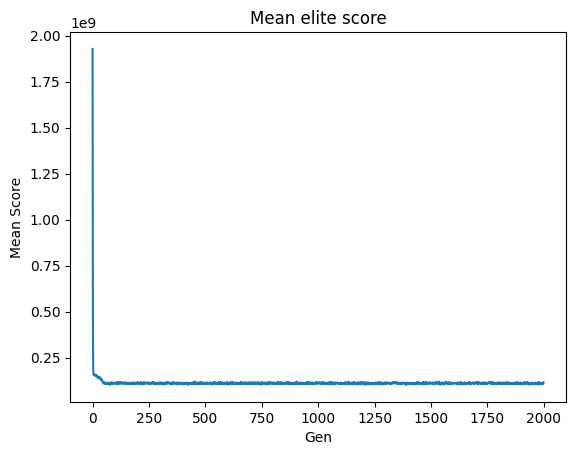

In [4]:
plt.plot(mean_elite_scores)
plt.xlabel('Gen')
plt.ylabel('Mean Score')
plt.title('Mean elite score')

Text(0, 0.5, 'Max Stds')

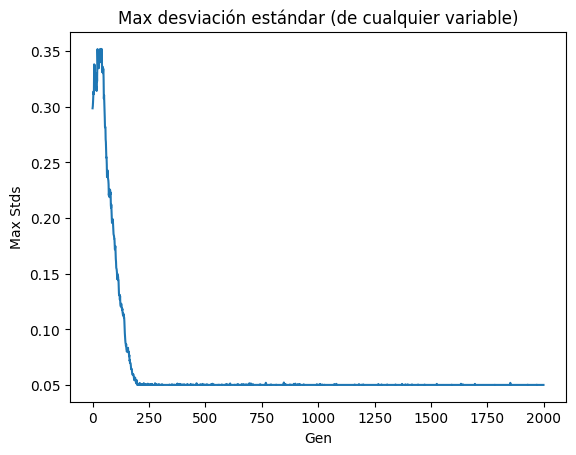

In [5]:
plt.plot(elite_stds)
plt.title('Max desviación estándar (de cualquier variable)')
plt.xlabel('Gen')
plt.ylabel('Max Stds')

Text(0.5, 1.0, 'Best ind vs Best born score')

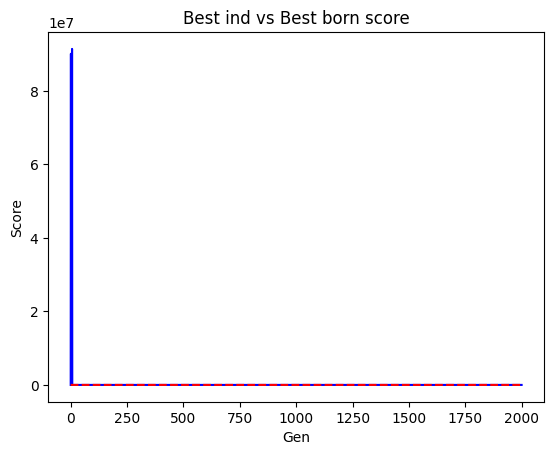

In [6]:
plt.plot(humanity[:,0,-1], 'b-')
plt.plot(elite_humanity[:,0,-1], 'r--')
plt.xlabel('Gen')
plt.ylabel('Score')
plt.title('Best ind vs Best born score')

In [7]:
# scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
scores = functions.parallel_apply_along_axis(oned_well.compute_z_triangles, 1, elite_humanity[-4,:,:-1])
best_score = min(scores)
best_individual = population[np.argmin(scores)]
print(best_score)

0.04622633069794194


In [8]:
def Psi_n(n):
    return (2 / well_length) ** 0.5 * np.sin(
        n * np.pi * np.linspace(0, well_length, n_variables) / well_length
    )


# integral = 0
# for i in range(len(best_individual)):
#     integral = integral + (best_individual[i] ** 2) * (well_length / (n_variables - 1))

# B = (1 / integral) ** 0.5
# best_individual = B * best_individual

# Normalización soluciones
$\int|\Psi(x)|²dx = 1$

In [9]:
n_best

800

In [10]:
n_variables

25

In [11]:
Nelite_humanity = np.empty(np.shape(elite_humanity))
for gen in range(len(elite_humanity)):
    for ind in range(len(elite_humanity[0,:,0])):
        inte = 0
        for vars in range(len(elite_humanity[0,0,:-1])):
            inte += elite_humanity[gen,ind,vars]**2*(well_length/(n_variables-1))
        A = (1/inte)**0.5
        Nelite_humanity[gen, ind, :-1] = A * elite_humanity[gen, ind, :-1]
        Nelite_humanity[gen, ind, -1] = elite_humanity[gen, ind, -1]

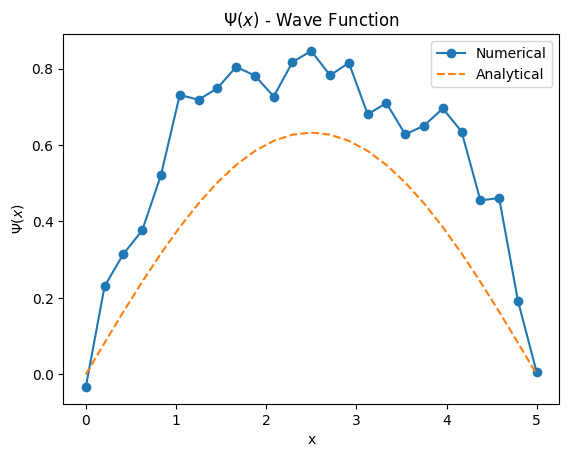

In [12]:
plt.plot(np.linspace(0, 5, n_variables), best_individual, label="Numerical", marker = "o")
plt.plot(np.linspace(0, 5, n_variables), Psi_n(1), "--", label="Analytical")
plt.gca().set_title("$\Psi(x)$ - Wave Function")
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("$\Psi(x)$")
plt.legend()

In [13]:
from IPython.display import clear_output
import time
import ipywidgets as widgets
from ipywidgets import interact
import pandas as pd

# Function to update the plot based on the selected generation
def update_plot(i):
    max_generation = len(Nelite_humanity)-1
    plt.figure(figsize=(20, 8))
    plt.clf()  # Clear previous plot

    edadf = pd.DataFrame(Nelite_humanity[i, :, :-1], columns=np.arange(0, n_variables, 1).tolist())
    edadf['ev'] = Nelite_humanity[i, :, -1]
    min_ev_row_index = edadf['ev'].idxmin()
    min_ev_row_data = edadf.iloc[min_ev_row_index, :-1].tolist()

    generation_slider.max = max_generation
    #generation_slider.value = min(i, max_generation)

    data = []
    for col in edadf:
        data.append(edadf[col])

    plt.violinplot(data[:-1], showmeans=True)
    plt.plot(np.arange(1, len(min_ev_row_data) + 1), min_ev_row_data, label='Best individual', color='red')
    plt.plot(np.arange(1, n_variables+1, 1), Psi_n(1), 'k-', label='Analytic solution')
    plt.legend()
    plt.xlabel("Variables")
    plt.xticks(np.arange(1, n_variables+1, 1))
    plt.ylim(0,1)
    # ## Dynamic y lims
    # if n ==E_level_keys[0] or n==E_level_keys[1]:
    #     plt.ylim(0,1)
    # else: plt.ylim((-2,2))
    
    plt.ylabel("Valores")
    plt.title(f"Gen {i}")
    plt.legend()

    plt.suptitle('Evolución Individuos', fontsize=20)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Create a slider widget
#E_level_keys = list(Nelite_humanity.keys())
#E_level_slider = widgets.Dropdown(options=E_level_keys, value=E_level_keys[0], description='E level', layout=widgets.Layout(width='100%'), orientation = 'horizontal')
generation_slider = widgets.IntSlider(value=0, min=0, max=0, #len(Nelite_humanity[E_level_slider])-1,
                                       step=1, description='Generation', layout=widgets.Layout(width='100%'))


# Use interact to connect the slider with the update_plot function
interact(update_plot, i=generation_slider)#, n=E_level_slider);

interactive(children=(IntSlider(value=0, description='Generation', layout=Layout(width='100%'), max=1999), Out…

<function __main__.update_plot(i)>

## EDA forzando valores desde extremos a centro

A partir de la iteración 50 (donde suponemos que todas las soluciones propuestas estarán aprendiendo las condiciones de contorno) vamos a forzar las distribuciones de las amplitudes intermedias. 

In [14]:
#### EDA 
#### EDA parameters
generations = 800 
generation_size = 400 ## Individuals each gen
alpha = 0.5 ## % of individuals to learn pm
n_best = int(generation_size * alpha) ## Indivs to learn pm
convergence_threshold = 0.001 ## 

## Problem parameters
n_variables = 50 
well_length = 5

# TODO: añadir sampleo para variables continuas que tenga en cuenta span(x)/dim(x)
# TODO: añadir un módulo de interpolación de una función analítica con los puntos de x
# TODO: añadir visualización de la pérdida
# TODO: mejorar la aproximación de la integral (triángulos? montecarlo?), segmentándola en el proceso
# TODO: sampleo uniforme de muestras entre [mu+n*sigma, mu-n*sigma]?
# TODO: por que se estropea para muchos puntos :(((
# TODO: para niveles de energía excitados obtener la energía esperada de los estados previos
# TODO: Preservar mejor individuo ever: Si hay un individuo en la generación i-1 mejor que cualquiera de la i se pierde.!!!!!!!!!!!!!!!!!!!!!!!!!
# TODO: Problema multiobjetivo.........


# Initialization
population = np.random.random([generation_size, n_variables]) ## Initial Psi(x) amplitudes. Random numbers [0,1)
mean_elite_scores = [] ## List to store mean score of selected inds
elite_stds = [] ## List with Standard Deviation of selected individuals each gen
humanity = [] ## Empty list to store all individuals ever existed
elite_humanity = [] ## Empty list to store elite individuals ever existed
dadndson_sorted_selected = np.empty((1,n_variables+1)) ## Empty array to compare dad&sons first time
dadndson_sorted_selected[0,-1] = np.infty ## Score 
# Generation loop
with alive_bar(
    0, force_tty=True, bar=None, theme="scuba", stats=False, stats_end=False
) as bar:
    for generation in range(generations):
        bar()

        ## Evaluación individuos
        # scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
        scores = functions.parallel_apply_along_axis(oned_well.compute_z_triangles, 1, population) ## axis=1 rows, axis=0 columns
        # max_scores_index = np.argpartition(scores, -n_best)[-n_best:] # (si fuese maximizar)

        # Store inidividuals + score, first we add evaluation column to generation array to create a (inds, variables+eval) array sorted by score
        temp_arr =  np.column_stack((population, scores))
        dadndson = np.concatenate((temp_arr, dadndson_sorted_selected[:,:]), axis=0) #Pegamos los individuos generados con los mejores de la anterior generación
        sort_index = np.argsort(dadndson[:,-1])
        dadndson_sorted = dadndson[sort_index] #Ordenamos todos según fitness
        dadndson_sorted_selected = dadndson_sorted[:n_best, :] #Nos quedamos con los mejores de entre ellos para actualiza pm
        selected_inds_sorted = dadndson_sorted_selected

        # Seleccionamos los mejores de la población generada
        # Get the indices that would sort the last column
        sorted_index = np.argsort(temp_arr[:, -1]) ### Para revertir orden (si fuera maximizar)[::-1]
        # Reorder the rows of the array based on the sorted indices
        sorted_inds = temp_arr[sorted_index] ## Sorted by score 2D array of generated population
    
        #Now we add a dimension (generation), axis at the beginning
        sorted_inds = np.expand_dims(sorted_inds, axis=0)  ## 3D Numpy array to store all individuals ever existed (gen, inds, variables+score)
        selected_inds_sorted = np.expand_dims(selected_inds_sorted, axis=0) ## best between all indivs
        humanity.append(sorted_inds)
        elite_humanity.append(selected_inds_sorted) ## 3D Numpy array to store selected individuals in each gen

        ## Aprendizaje modelo probabilístico UMDA
        best_individuals_mean = dadndson_sorted_selected[:,:-1].transpose().mean(axis=1)
        best_individuals_std = dadndson_sorted_selected[:,:-1].transpose().std(axis=1)
        for i in range(len(best_individuals_std)):
            if best_individuals_std[i]<0.08:
                best_individuals_std[i] = 0.08

        ## Distribuciones condicionadas
        ### MEANS BASED ON DERIVATIVE
        # if generation >= 50:
        #     for amplitudes in range(1,n_variables//2):
        #         meansderivative = (best_individuals_mean[amplitudes]-best_individuals_mean[amplitudes-1])/(well_length/(n_variables-1))
        #         best_individuals_mean[amplitudes] = best_individuals_mean[amplitudes-1] + meansderivative * (well_length/n_variables-1)
        #         best_individuals_std[amplitudes] = 0.05
            # for amplitudes in range(-2, -n_variables//2+1,-1):
            #     meansderivative = (best_individuals_mean[amplitudes]-best_individuals_mean[amplitudes-1])/(well_length/(n_variables-1))
            #     best_individuals_mean[amplitudes] = best_individuals_mean[amplitudes+1] + meansderivative * (well_length/(n_variables-1))
            #     best_individuals_std[amplitudes] = 0.05
                
        ## MEANS BASED ON SEQUENTIAL VARIANCE
        for amplitudes in range(0,5):
            if best_individuals_mean[0] < 0.1:
                best_individuals_mean[amplitudes+1] = best_individuals_mean[amplitudes]

        for i in range(-1, -5, -1):
            if best_individuals_mean[-1] < 0.1:
                best_individuals_mean[i-1] = best_individuals_mean[i]

        ## EDA status: mean score, mean std
        mean_elite_score = dadndson_sorted_selected[:,-1].mean()
        elite_std = best_individuals_std.max()
        mean_elite_scores.append(mean_elite_score)
        elite_stds.append(elite_std)
        #print(sorted_inds)

        ## Bar Status
        bar.text("- best generated ind score: {:.4f}, best ind ever: {:.4f}".format(sorted_inds[0,0,-1] , selected_inds_sorted[0,0,-1]))
        
        ## Convergence Threshold 
        if best_individuals_std.max() < convergence_threshold:
            #population = best_individuals
            break
        else:
            population = np.random.normal(
                best_individuals_mean,
                best_individuals_std,
                [generation_size, n_variables],
            )

# converting humanity list to 3D numpy array
humanity = np.concatenate(humanity, axis=0)
elite_humanity = np.concatenate(elite_humanity, axis=0)
###########################################################

800 in 1:25.2                                                                    471 in 49s - best generated ind score: 508.1883, best ind ever: 137


In [15]:
for i in range(0,1):
    print(i)

0


In [16]:
for amplitudes in range(-2, -n_variables//2+1,-1):
    print(amplitudes, amplitudes+1)

-2 -1
-3 -2
-4 -3
-5 -4
-6 -5
-7 -6
-8 -7
-9 -8
-10 -9
-11 -10
-12 -11
-13 -12
-14 -13
-15 -14
-16 -15
-17 -16
-18 -17
-19 -18
-20 -19
-21 -20
-22 -21
-23 -22


In [17]:
for amplitudes in range(1,n_variables//2):
    print(amplitudes)   
    # best_individuals_mean[amplitudes] = best_individuals_mean[amplitudes-1]
    # best_individuals_std[amplitudes] = 0.1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


Text(0.5, 1.0, 'Best ind vs Best born score')

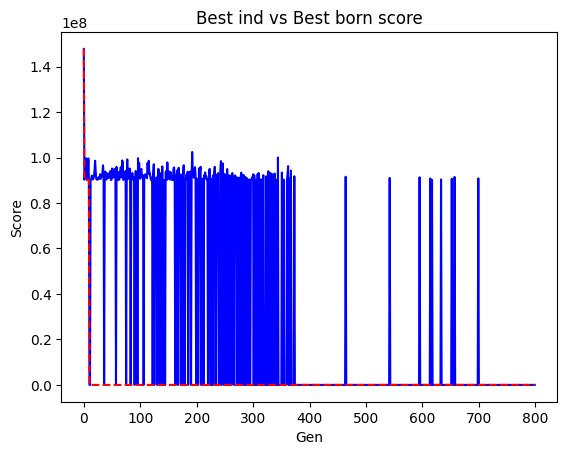

In [18]:
plt.plot(humanity[:,0,-1], 'b-')
plt.plot(elite_humanity[:,0,-1], 'r--')
plt.xlabel('Gen')
plt.ylabel('Score')
plt.title('Best ind vs Best born score')

In [19]:
Nelite_humanity = np.empty(np.shape(elite_humanity))
for gen in range(len(elite_humanity)):
    for ind in range(len(elite_humanity[0,:,0])):
        inte = 0
        for vars in range(len(elite_humanity[0,0,:-1])):
            inte += elite_humanity[gen,ind,vars]**2*(well_length/(n_variables-1))
        A = (1/inte)**0.5
        Nelite_humanity[gen, ind, :-1] = A * elite_humanity[gen, ind, :-1]
        Nelite_humanity[gen, ind, -1] = elite_humanity[gen, ind, -1]

In [20]:
from IPython.display import clear_output
import time
import ipywidgets as widgets
from ipywidgets import interact
import pandas as pd

# Function to update the plot based on the selected generation
def update_plot(i):
    max_generation = len(Nelite_humanity)-1
    plt.figure(figsize=(20, 8))
    plt.clf()  # Clear previous plot

    edadf = pd.DataFrame(Nelite_humanity[i, :, :-1], columns=np.arange(0, n_variables, 1).tolist())
    edadf['ev'] = Nelite_humanity[i, :, -1]
    min_ev_row_index = edadf['ev'].idxmin()
    min_ev_row_data = edadf.iloc[min_ev_row_index, :-1].tolist()

    generation_slider.max = max_generation
    #generation_slider.value = min(i, max_generation)

    data = []
    for col in edadf:
        data.append(edadf[col])

    plt.violinplot(data[:-1], showmeans=True)
    plt.plot(np.arange(1, len(min_ev_row_data) + 1), min_ev_row_data, label='Best individual', color='red')
    plt.plot(np.arange(1, n_variables+1, 1), Psi_n(1), 'k-', label='Analytic solution')
    plt.legend()
    plt.xlabel("Variables")
    plt.xticks(np.arange(1, n_variables+1, 1))
    plt.ylim(0,1)
    # ## Dynamic y lims
    # if n ==E_level_keys[0] or n==E_level_keys[1]:
    #     plt.ylim(0,1)
    # else: plt.ylim((-2,2))
    
    plt.ylabel("Valores")
    plt.title(f"Gen {i}")
    plt.legend()

    plt.suptitle('Evolución Individuos', fontsize=20)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Create a slider widget
#E_level_keys = list(Nelite_humanity.keys())
#E_level_slider = widgets.Dropdown(options=E_level_keys, value=E_level_keys[0], description='E level', layout=widgets.Layout(width='100%'), orientation = 'horizontal')
generation_slider = widgets.IntSlider(value=0, min=0, max=0, #len(Nelite_humanity[E_level_slider])-1,
                                       step=1, description='Generation', layout=widgets.Layout(width='100%'))


# Use interact to connect the slider with the update_plot function
interact(update_plot, i=generation_slider)#, n=E_level_slider);

interactive(children=(IntSlider(value=0, description='Generation', layout=Layout(width='100%'), max=799), Outp…

<function __main__.update_plot(i)>